In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import game_parser

In [32]:
X = np.load('data/training/X.npy', allow_pickle=True)
y = np.load('data/training/y.npy', allow_pickle=True)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1)

In [33]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.champ_fc1 = nn.Linear(304, 40)
        self.fc1 = nn.Linear(65, 50)
        self.d1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 2)

    
    def forward(self, x):
        c = self.champ_fc1(x[:, 1:305])
        c = F.leaky_relu(c)

        # n for new
        n = torch.cat((x[:, 0:1], c), dim=1)
        n = torch.cat((n, x[:, 305:]), dim=1)

        # print(n.shape)
        x = self.fc1(n)
        x = F.leaky_relu(x)
        x = self.d1(x)

        x = self.fc2(x)
        return x

In [34]:
features = [
    nn.Linear(329, 50, bias=False),
    nn.LeakyReLU(0.1),
    nn.Dropout(0.2),

    nn.Linear(50, 2, bias=False)
]

In [35]:
# hyperparameters
LR = 0.0001
EPOCHS = 2
BATCH_SIZE = 128

In [36]:
train_X = torch.tensor(train_X).float().cuda()
train_y = torch.tensor(train_y).long().cuda()
test_X = torch.tensor(test_X).float().cuda()
test_y = torch.tensor(test_y).long().cuda()

train_set = TensorDataset(train_X, train_y)
test_set = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [37]:
# model = nn.Sequential(*features).cuda()

model = Net().cuda()
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

In [38]:
# training:

losses, accuracies = [], []
val_losses, val_accs = [], []

for epoch in range(EPOCHS):
    t = tqdm(train_loader)
    for data in t:
        # TRAINING
        batch_X, batch_y = data

        model.train()
        outputs = model(batch_X)
        loss = loss_fn(outputs, batch_y)

        model.zero_grad()
        loss.backward()
        optimizer.step()

        # TESTING
        model.eval()
        test_outputs = model(test_X)
        val_loss = loss_fn(test_outputs, test_y)

        # LOGGING
        pred = torch.argmax(outputs, dim=1)
        accuracy = (pred == batch_y).float().mean()

        val_pred = torch.argmax(test_outputs, dim=1)
        val_acc = (val_pred == test_y).float().mean()

        losses.append(loss.item())
        accuracies.append(accuracy.item())

        val_losses.append(val_loss.item())
        val_accs.append(val_acc.item())

        t.set_description(f'Train: [L: {loss:.4f}, Acc: {accuracy:.4f}] --- Test: [L: {val_loss:.4f}, Acc: {val_acc:.4f}]')

Train: [L: 0.5557, Acc: 0.6883] --- Test: [L: 0.5551, Acc: 0.7038]: 100%|██████████| 1701/1701 [00:12<00:00, 136.11it/s]
Train: [L: 0.5576, Acc: 0.6883] --- Test: [L: 0.4639, Acc: 0.7845]: 100%|██████████| 1701/1701 [00:12<00:00, 135.18it/s]


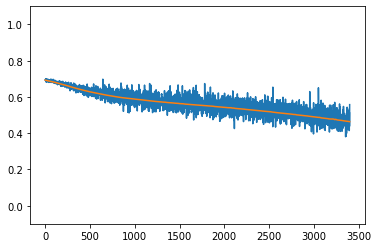

In [39]:
plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(val_losses)

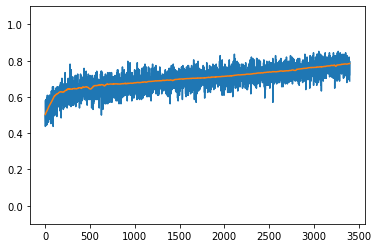

In [40]:
plt.ylim(-0.1, 1.1)
plt.plot(accuracies)
plt.plot(val_accs)

In [41]:
data = game_parser.custom_game(timestamp=0, 
champions=['Shen', 'Graves', 'Syndra', 'Senna', 'Alistar', 'Shen', 'Graves', 'Syndra', 'Senna', 'Alistar'], 
blue_gold=2500, red_gold=2500, blue_exp=0, red_exp=0, bk=0, rk=0, bt=11, rt=11, bi=3, ri=3,
bm=[0,0,0,0,0,0,0], 
rm=[0,0,0,0,0,0,0])
# air earth fire water elder herald baron
data = torch.tensor(data).float().cuda().reshape(-1, 329)
model.eval()
pred = model(data)
prob = F.softmax(pred)
print(prob)

tensor([[0.3338, 0.6662]], device='cuda:0', grad_fn=<SoftmaxBackward>)


In [42]:
train_X[:,305:]

tensor([[0.0979, 0.1000, 0.1219,  ..., 0.0000, 0.0000, 0.0000],
        [0.2553, 0.2488, 0.2878,  ..., 0.0000, 0.0000, 0.0000],
        [0.4556, 0.5471, 0.5793,  ..., 0.0000, 1.0000, 1.0000],
        ...,
        [0.5354, 0.5169, 0.7171,  ..., 0.0000, 1.0000, 0.0000],
        [0.1146, 0.0958, 0.1171,  ..., 0.0000, 0.0000, 0.0000],
        [0.1287, 0.0946, 0.1408,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [43]:
train_X[:,1:305].shape

torch.Size([217677, 304])

In [44]:
a = [[1,2,3],
     [1,2,3]]
b = [[4,5,6],
     [4,5,6]]
a,b = torch.tensor(a), torch.tensor(b)

torch.cat((a[:,0:1],b), dim=1)

tensor([[1, 4, 5, 6],
        [1, 4, 5, 6]])

In [45]:
train_X[:,0:1]

tensor([[0.1751],
        [0.3501],
        [0.6502],
        ...,
        [0.7252],
        [0.1750],
        [0.1751]], device='cuda:0')